In [1]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from collections import deque
from scipy.special import logsumexp
from scipy.stats import invgauss, norm, skew, kurtosis
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import pickle


SEED = 42
rng = np.random.default_rng(SEED)

## Categorical "Astro" distribution

In [3]:
init_cost = 2

# Astro numbers
N = 4500000
gains = [2, 4, 6, 10, 20, 100, 1000, 25000]
ns = [661500, 476000, 150000, 101350, 45000, 415, 8, 3]

# Add loss event
gains.insert(0, 0)
ns.insert(0, N - sum(ns))

ps = np.array(ns) / N
xs = init_cost - np.array(gains)


class Categorical:
    def __init__(self, xs, ps, rng=np.random.default_rng(0)):
        self.xs = xs
        self.ps = ps
        self.rng = rng
    
    def rvs(self, size=1):
        return self.rng.choice(self.xs, p=self.ps, size=size)
    
    @property
    def mean(self):
        return self.xs @ self.ps
    
    @property
    def var(self):
        return self.ps @ (self.xs ** 2) - self.mean ** 2

    @property
    def std(self):
        return np.sqrt(self.var)

    
class CategoricalNoReplacement:
    def __init__(self, gains, ns, init_cost, rng=np.random.default_rng(0), shuffle=True, no_restart=True):
        self.gains = gains
        self.ns = ns
        self.xs = -(np.concatenate([np.repeat([gain], n) for gain, n in zip(gains, ns)]) - init_cost)
        self.rng = rng
        self.shuffle = shuffle
        self.no_restart = no_restart
    
    def rvs(self, size=1):
        if isinstance(size, tuple):
            L = np.prod(size)
        else:
            L = size
        if L <= len(self.xs):
            return self.rng.choice(self.xs, replace=False, size=L, shuffle=self.shuffle).reshape(size)
        else:
            if self.no_restart:
                raise Exception("Cannot sample more than {} times without replacement!".format(len(self.xs)))
            ret = []
            l = len(self.xs)
            while L > len(self.xs):
                ret.append(self.rvs(size=l))
                L -= l
            ret.append(self.rvs(size=L))
            return np.concatenate(ret).reshape(size)
            
    @property
    def mean(self):
        return np.mean(self.xs)
    
    @property
    def var(self):
        return np.var(self.xs)

    @property
    def std(self):
        return np.std(self.xs)
    

distr = Categorical(xs, ps, rng=rng)
distr_nr = CategoricalNoReplacement(gains, ns, init_cost, rng=rng)

## Gaussian approximation
$X_t = \mu t + \sigma W_t$

In [4]:
mu = distr.mean
sigma = distr.std

pd.DataFrame(
    np.round([mu, sigma], 2).reshape(1, 2),
    index=['stats'],
    columns=['$\mu$', '$\sigma$'],
)

,$\mu$,$\sigma$
stats,0.63,20.67


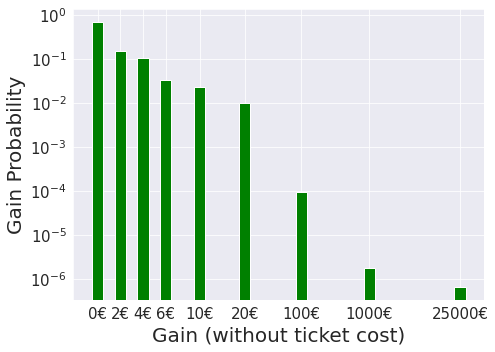

In [5]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    
    xplot = [0., 1., 2., 3., 4.5, 6.5, 9., 12., 16.]
    
    ax.bar(xplot, distr.ps, width=0.5, color='green')

    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel('Gain (without ticket cost)', fontsize=20)
    ax.set_ylabel('Gain probability', fontsize=20)
    
    ax.set_xticks(xplot)
    ax.set_xticklabels(['{:}€'.format(x) for x in -distr.xs + 2])
    ax.set_yscale('log')
    
    plt.tight_layout()
    plt.show()

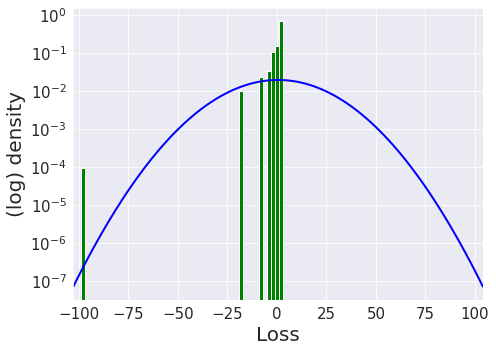

In [6]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    
    xx = np.linspace(mu - 5 * sigma, mu + 5 * sigma, 100)
    
    ax.bar(distr.xs, distr.ps, width=2, color='green', label='simulated')
    ax.plot(xx, norm(loc=mu, scale=sigma).pdf(xx), color='blue', linewidth=2, label='Gaussian approx.')

    ax.tick_params(axis='both', which='major', labelsize=15)
    
    ax.set_xlabel('Loss', fontsize=20)
    ax.set_ylabel('(log) density', fontsize=20)
    ax.legend(loc='upper right', prop={'size': 15})
    
    ax.set_yscale('log')
    ax.set_xlim([mu - 5 * sigma, mu + 5 * sigma])
    
    plt.tight_layout()
    plt.show()

In [7]:
T = int(4.5e6)
M = int(1e1)
tt = np.linspace(1, T, T)

astro_samples = distr.rvs(size=(M, T))
gauss_samples = rng.normal(loc=mu, scale=sigma, size=(M, T))
astro_nr_samples = np.empty((M, T))
for m in tqdm(range(M)):
    astro_nr_samples[m, :] = distr_nr.rvs(T)

astro_mu_hats = np.cumsum(astro_samples, axis=1) / tt
astro_nr_mu_hats = np.cumsum(astro_nr_samples, axis=1) / tt
astro_sigma_hats = np.sqrt(np.cumsum(astro_samples ** 2, axis=1) / tt - astro_mu_hats ** 2)

astro_nr_sigma_hats = np.sqrt(np.cumsum(astro_nr_samples ** 2, axis=1) / tt - astro_nr_mu_hats ** 2)
gauss_mu_hats = np.cumsum(gauss_samples, axis=1) / tt
gauss_sigma_hats = np.sqrt(np.cumsum(gauss_samples ** 2, axis=1) / tt - gauss_mu_hats ** 2)

astro_mean = np.mean(astro_mu_hats, axis=0)
astro_mean_q_25 = np.quantile(astro_mu_hats, q=0.25, axis=0)
astro_mean_q_75 = np.quantile(astro_mu_hats, q=0.75, axis=0)

astro_std = np.mean(astro_sigma_hats, axis=0)
astro_std_q_25 = np.quantile(astro_sigma_hats, q=0.25, axis=0)
astro_std_q_75 = np.quantile(astro_sigma_hats, q=0.75, axis=0)

astro_nr_mean = np.mean(astro_nr_mu_hats, axis=0)
astro_nr_mean_q_25 = np.quantile(astro_nr_mu_hats, q=0.25, axis=0)
astro_nr_mean_q_75 = np.quantile(astro_nr_mu_hats, q=0.75, axis=0)

astro_nr_std = np.mean(astro_nr_sigma_hats, axis=0)
astro_nr_std_q_25 = np.quantile(astro_nr_sigma_hats, q=0.25, axis=0)
astro_nr_std_q_75 = np.quantile(astro_nr_sigma_hats, q=0.75, axis=0)

gauss_mean = np.mean(gauss_mu_hats, axis=0)
gauss_mean_q_25 = np.quantile(gauss_mu_hats, q=0.25, axis=0)
gauss_mean_q_75 = np.quantile(gauss_mu_hats, q=0.75, axis=0)

gauss_std = np.mean(gauss_sigma_hats, axis=0)
gauss_std_q_25 = np.quantile(gauss_sigma_hats, q=0.25, axis=0)
gauss_std_q_75 = np.quantile(gauss_sigma_hats, q=0.75, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

## Comparison between true Astro distribution and Gaussian approximation

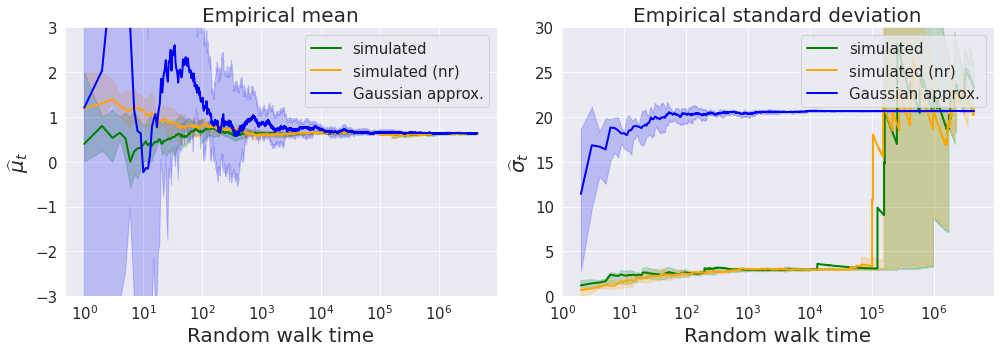

In [8]:
with sns.axes_style('darkgrid'):
    fig, axes = plt.subplots(figsize=(14, 5), nrows=1, ncols=2)
    
    ax = axes[0]
    ax.plot(tt, astro_mean, color='green', linewidth=2, label='simulated')
    ax.fill_between(tt, y1=astro_mean_q_25, y2=astro_mean_q_75, alpha=0.2, color='green')

    ax.plot(tt, astro_nr_mean, color='orange', linewidth=2, label='simulated (nr)')
    ax.fill_between(tt, y1=astro_nr_mean_q_25, y2=astro_nr_mean_q_75, alpha=0.2, color='orange')

    ax.plot(tt, gauss_mean, color='blue', linewidth=2, label='Gaussian approx.')
    ax.fill_between(tt, y1=gauss_mean_q_25, y2=gauss_mean_q_75, alpha=0.2, color='blue')

    ax.legend(loc='upper right', prop={'size': 15})
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel('Random walk time', fontsize=20)
    ax.set_ylabel('$\widehat{\mu}_t$', fontsize=20)
    ax.set_title('Empirical mean', fontsize=20)
    
    ax.set_ylim([-3, 3])
    ax.set_xscale('log')
    
    ax = axes[1]
    ax.plot(tt[1:], astro_std[1:], color='green', linewidth=2, label='simulated')
    ax.fill_between(tt[1:], y1=astro_std_q_25[1:], y2=astro_std_q_75[1:], alpha=0.2, color='green')

    ax.plot(tt[1:], astro_nr_std[1:], color='orange', linewidth=2, label='simulated (nr)')
    ax.fill_between(tt[1:], y1=astro_nr_std_q_25[1:], y2=astro_nr_std_q_75[1:], alpha=0.2, color='orange')

    ax.plot(tt[1:], gauss_std[1:], color='blue', linewidth=2, label='Gaussian approx.')
    ax.fill_between(tt[1:], y1=gauss_std_q_25[1:], y2=gauss_std_q_75[1:], alpha=0.2, color='blue')

    ax.set_ylim([0, 30])
    ax.set_xscale('log')

    ax.legend(loc='upper right', prop={'size': 15})
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel('Random walk time', fontsize=20)
    ax.set_ylabel('$\widehat{\sigma}_t$', fontsize=20)
    ax.set_title('Empirical standard deviation', fontsize=20)
    
    plt.tight_layout()
    plt.show()

In [9]:
T_short = int(1e2)
T_long = int(1e4)


def _empirical_short_log_laplace_transform(x):
    n = len(astro_mu_hats[:, T_short])
    return logsumexp(x * astro_mu_hats[:, T_short] - np.log(n))


def _empirical_short_log_laplace_transform_q_25(x):
    return np.quantile(x * astro_mu_hats[:, T_short], q=0.25)


def _empirical_short_log_laplace_transform_q_75(x):
    return np.quantile(x * astro_mu_hats[:, T_short], q=0.75)


def _empirical_long_log_laplace_transform(x):
    n = len(astro_mu_hats[:, T_long])
    return logsumexp(x * astro_mu_hats[:, T_long] - np.log(n))


def _empirical_long_log_laplace_transform_q_25(x):
    return np.quantile(x * astro_mu_hats[:, T_long], q=0.25)


def _empirical_long_log_laplace_transform_q_75(x):
    return np.quantile(x * astro_mu_hats[:, T_long], q=0.75)


empirical_short_log_laplace_transform = np.vectorize(_empirical_short_log_laplace_transform)
empirical_short_log_laplace_transform_q_25 = np.vectorize(_empirical_short_log_laplace_transform_q_25)
empirical_short_log_laplace_transform_q_75 = np.vectorize(_empirical_short_log_laplace_transform_q_75)

empirical_long_log_laplace_transform = np.vectorize(_empirical_long_log_laplace_transform)
empirical_long_log_laplace_transform_q_25 = np.vectorize(_empirical_long_log_laplace_transform_q_25)
empirical_long_log_laplace_transform_q_75 = np.vectorize(_empirical_long_log_laplace_transform_q_75)


def _empirical_nr_short_log_laplace_transform(x):
    n = len(astro_nr_mu_hats[:, T_short])
    return logsumexp(x * astro_nr_mu_hats[:, T_short] - np.log(n))


def _empirical_nr_short_log_laplace_transform_q_25(x):
    return np.quantile(x * astro_nr_mu_hats[:, T_short], q=0.25)


def _empirical_nr_short_log_laplace_transform_q_75(x):
    return np.quantile(x * astro_nr_mu_hats[:, T_short], q=0.75)


def _empirical_nr_long_log_laplace_transform(x):
    n = len(astro_nr_mu_hats[:, T_long])
    return logsumexp(x * astro_nr_mu_hats[:, T_long] - np.log(n))


def _empirical_nr_long_log_laplace_transform_q_25(x):
    return np.quantile(x * astro_nr_mu_hats[:, T_long], q=0.25)


def _empirical_nr_long_log_laplace_transform_q_75(x):
    return np.quantile(x * astro_nr_mu_hats[:, T_long], q=0.75)


empirical_nr_short_log_laplace_transform = np.vectorize(_empirical_nr_short_log_laplace_transform)
empirical_nr_short_log_laplace_transform_q_25 = np.vectorize(_empirical_nr_short_log_laplace_transform_q_25)
empirical_nr_short_log_laplace_transform_q_75 = np.vectorize(_empirical_nr_short_log_laplace_transform_q_75)

empirical_nr_long_log_laplace_transform = np.vectorize(_empirical_nr_long_log_laplace_transform)
empirical_nr_long_log_laplace_transform_q_25 = np.vectorize(_empirical_nr_long_log_laplace_transform_q_25)
empirical_nr_long_log_laplace_transform_q_75 = np.vectorize(_empirical_nr_long_log_laplace_transform_q_75)


def gaussian_short_log_laplace_transform(x):
    return mu * x + 0.5 * sigma ** 2 * x ** 2 / T_short

def gaussian_long_log_laplace_transform(x):
    return mu * x + 0.5 * sigma ** 2 * x ** 2 / T_long

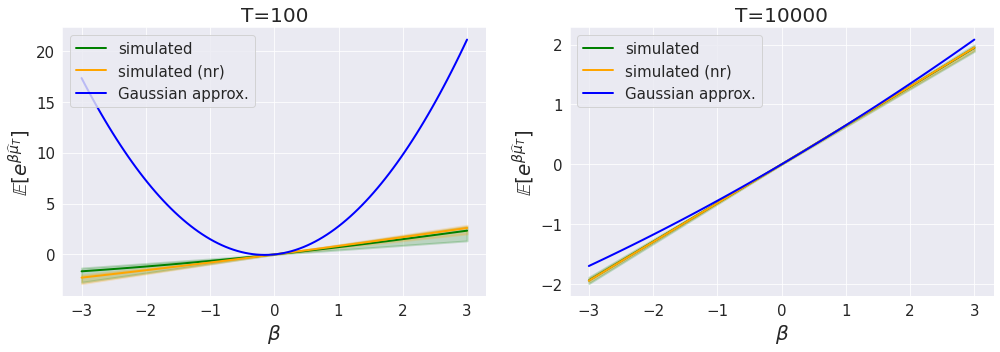

In [10]:
xx = np.linspace(-3, 3, 100)

with sns.axes_style('darkgrid'):
    fig, axes = plt.subplots(figsize=(14, 5), nrows=1, ncols=2)
    
    ax = axes[0]
    ax.plot(xx, empirical_short_log_laplace_transform(xx), color='green', linewidth=2, label='simulated')
    ax.fill_between(xx, y1=empirical_short_log_laplace_transform_q_25(xx), y2=empirical_short_log_laplace_transform_q_75(xx), alpha=0.2, color='green', linewidth=2)

    ax.plot(xx, empirical_nr_short_log_laplace_transform(xx), color='orange', linewidth=2, label='simulated (nr)')
    ax.fill_between(xx, y1=empirical_nr_short_log_laplace_transform_q_25(xx), y2=empirical_nr_short_log_laplace_transform_q_75(xx), alpha=0.2, color='orange', linewidth=2)

    ax.plot(xx, gaussian_short_log_laplace_transform(xx), color='blue', linewidth=2, label='Gaussian approx.')
    
    ax.legend(loc='upper left', prop={'size': 15})
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel(r'$\beta$', fontsize=20)
    ax.set_ylabel(r'$\mathbb{E}[e^{\beta \widehat{\mu}_T}]$', fontsize=20)
    ax.set_title('T={:.0f}'.format(T_short), fontsize=20)
    
    ax = axes[1]
    ax.plot(xx, empirical_long_log_laplace_transform(xx), color='green', linewidth=2, label='simulated')
    ax.fill_between(xx, y1=empirical_long_log_laplace_transform_q_25(xx), y2=empirical_long_log_laplace_transform_q_75(xx), alpha=0.2, color='green', linewidth=2)

    ax.plot(xx, empirical_nr_long_log_laplace_transform(xx), color='orange', linewidth=2, label='simulated (nr)')
    ax.fill_between(xx, y1=empirical_nr_long_log_laplace_transform_q_25(xx), y2=empirical_nr_long_log_laplace_transform_q_75(xx), alpha=0.2, color='orange', linewidth=2)

    ax.plot(xx, gaussian_long_log_laplace_transform(xx), color='blue', linewidth=2, label='Gaussian approx.')
    
    ax.legend(loc='upper left', prop={'size': 15})
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel(r'$\beta$', fontsize=20)
    ax.set_ylabel(r'$\mathbb{E}[e^{\beta \widehat{\mu}_T}]$', fontsize=20)
    ax.set_title('T={:.0f}'.format(T_long), fontsize=20)
    
    plt.tight_layout()
    plt.show()

## Approximate hitting time by inverse Gaussian

In [11]:
mu_inv_gauss = sigma ** 2 / (init_cost * mu)
scale = init_cost ** 2 / sigma ** 2

distr_invgauss = invgauss(mu_inv_gauss, scale=scale) 

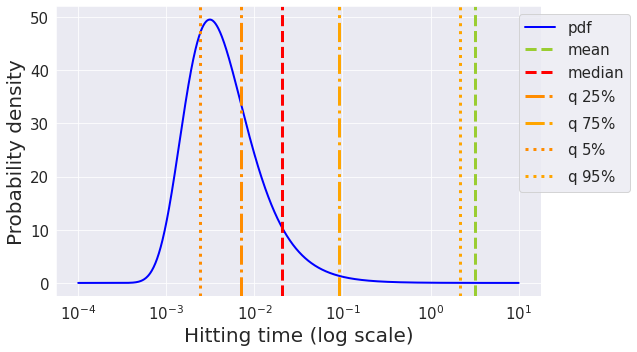

In [12]:
# g = lambda t: init_cost / sigma / np.sqrt(2 * np.pi * t ** 3) * np.exp(-(init_cost - mu * t) ** 2 / (2 * sigma ** 2 * t ))
tt = np.logspace(-4, 1, 1000)

with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(9, 5), nrows=1, ncols=1)
    
    ax.plot(tt, distr_invgauss.pdf(tt), color='blue', linewidth=2, label='pdf')
    
    ax.axvline(x=distr_invgauss.mean(), color='yellowgreen', linestyle='dashed', linewidth=3, label='mean')
    ax.axvline(x=distr_invgauss.median(), color='red', linestyle='dashed', linewidth=3, label='median')
    ax.axvline(x=distr_invgauss.ppf(0.25), color='darkorange', linestyle='dashdot', linewidth=3, label='q $25\%$')
    ax.axvline(x=distr_invgauss.ppf(0.75), color='orange', linestyle='dashdot', linewidth=3, label='q $75\%$')
    ax.axvline(x=distr_invgauss.ppf(0.05), color='darkorange', linestyle='dotted', linewidth=3, label='q $5\%$')
    ax.axvline(x=distr_invgauss.ppf(0.95), color='orange', linestyle='dotted', linewidth=3, label='q $95\%$')
    
#     ax.plot(tt, g(tt), color='red',  linestyle='dashed', linewidth=3, label='formula')

    ax.set_xscale('log')

    ax.legend(loc='upper right', prop={'size': 15}, bbox_to_anchor=(1.2, 1.0))
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel('Hitting time (log scale)', fontsize=20)
    ax.set_ylabel('Probability density', fontsize=20)
    
    plt.tight_layout()
    plt.show()

## Simulation of categorical random walk hitting time

In [13]:
with open('results/astro_hitting_time_159071.pkl', 'rb') as f:
# with open('results/astro_hitting_time_976470.pkl', 'rb') as f:
    res = pickle.load(f)
    unique = res['results']['unique'].astype('int32')
    counts = res['results']['counts'].astype('int32')
    unique_nr = res['results']['unique_nr'].astype('int32')
    counts_nr = res['results']['counts_nr'].astype('int32')
    samples = np.concatenate([np.repeat([u], n) for u, n in zip(unique, counts)])
    samples_nr = np.concatenate([np.repeat([u], n) for u, n in zip(unique_nr, counts_nr)])

In [14]:
# def sample_tau(distr, thresh, size=1, t_max=4.5e6, buffer_size=100, verbose=False):
#     assert thresh > 0, "threshold must be > 0!"
#     samples = np.empty(size, dtype=int)
#     buffer_idx = 0
#     for i in tqdm(range(size), disable=not verbose):
#         # init random walk and hitting time
#         random_walk = 0.0
#         t = 0
        
#         while random_walk < thresh and t < t_max:
#             if buffer_idx % buffer_size == 0:
#                 increments = distr.rvs(size=buffer_size)
#             random_walk += increments[buffer_idx % buffer_size]
#             t += 1
#             buffer_idx += 1
#         samples[i] = t

#     return samples

# M = int(1e6)
# samples = sample_tau(distr, init_cost, buffer_size=100, size=M, verbose=True)
# samples_nr = sample_tau(distr_nr, init_cost, buffer_size=int(4.5e6), size=M, verbose=True)

In [15]:
pd.DataFrame(
    np.round(
        [
            [np.mean(samples), np.std(samples), skew(samples), kurtosis(samples), np.quantile(samples, 0.05), np.quantile(samples, 0.25), np.quantile(samples, 0.5), np.quantile(samples, 0.75), np.quantile(samples, 0.95)],
            [np.mean(samples_nr), np.std(samples_nr), skew(samples_nr), kurtosis(samples_nr), np.quantile(samples_nr, 0.05), np.quantile(samples_nr, 0.25), np.quantile(samples_nr, 0.5), np.quantile(samples_nr, 0.75), np.quantile(samples_nr, 0.95)],
            [distr_invgauss.mean(), distr_invgauss.std(), distr_invgauss.stats(moments='s'), distr_invgauss.stats(moments='k'), distr_invgauss.ppf(0.05), distr_invgauss.ppf(0.25), distr_invgauss.ppf(0.5), distr_invgauss.ppf(0.75), distr_invgauss.ppf(0.95)],
        ],
        2
    ).reshape(3, -1),
    index=['simulated', 'simulated (nr)', 'gaussian approx'],
    columns=['mean', 'std_dev', 'skew', 'kurtosis','q_05', 'q_25', 'q_50', 'q_75', 'q_95'],
)

,mean,std_dev,skew,kurtosis,q_05,q_25,q_50,q_75,q_95
simulated,3.20,60.83,624.97,399632.31,1.0,1.00,1.00,2.00,11.00
simulated (nr),3.19,77.84,881.59,826114.16,1.0,1.00,1.00,2.00,11.00
gaussian approx,3.17,58.46,55.24,5085.98,0.0,0.01,0.02,0.09,2.14


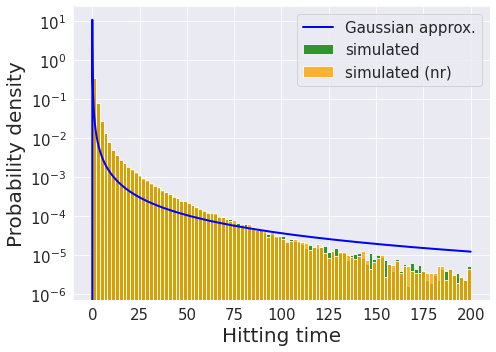

In [16]:
T = 200
tt = np.linspace(0, T, 10000)

with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    
    ax.plot(tt, distr_invgauss.pdf(tt), color='blue', linewidth=2, label='Gaussian approx.')
    ax.hist(samples, bins=T // 2, range=[0, T], density=True, color='green', alpha=0.8, label='simulated')
    ax.hist(samples_nr, bins=T // 2, range=[0, T], density=True, color='orange', alpha=0.8, label='simulated (nr)')
    
    ax.set_yscale('log')

    ax.legend(loc='upper right', prop={'size': 15})
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel('Hitting time', fontsize=20)
    ax.set_ylabel('Probability density', fontsize=20)
    
    plt.tight_layout()
    plt.show()

In [17]:
def _empirical_log_laplace_transform(x):
    n = len(samples)
    return logsumexp(-x * samples - np.log(n))

def _empirical_log_laplace_transform_q_25(x):
    return np.quantile(-x * samples, q=0.25)

def _empirical_log_laplace_transform_q_75(x):
    return np.quantile(-x * samples, q=0.75)

empirical_log_laplace_transform = np.vectorize(_empirical_log_laplace_transform)
empirical_log_laplace_transform_q_25 = np.vectorize(_empirical_log_laplace_transform_q_25)
empirical_log_laplace_transform_q_75 = np.vectorize(_empirical_log_laplace_transform_q_75)

def _empirical_nr_log_laplace_transform(x):
    n = len(samples_nr)
    return logsumexp(-x * samples_nr - np.log(n))

def _empirical_nr_log_laplace_transform_q_25(x):
    return np.quantile(-x * samples_nr, q=0.25)

def _empirical_nr_log_laplace_transform_q_75(x):
    return np.quantile(-x * samples_nr, q=0.75)

empirical_nr_log_laplace_transform = np.vectorize(_empirical_nr_log_laplace_transform)
empirical_nr_log_laplace_transform_q_25 = np.vectorize(_empirical_nr_log_laplace_transform_q_25)
empirical_nr_log_laplace_transform_q_75 = np.vectorize(_empirical_nr_log_laplace_transform_q_75)

def invgausslog_laplace_transform(x):
    return -init_cost / sigma * (-mu / sigma + np.sqrt(mu ** 2 / sigma ** 2 + 2 * x))

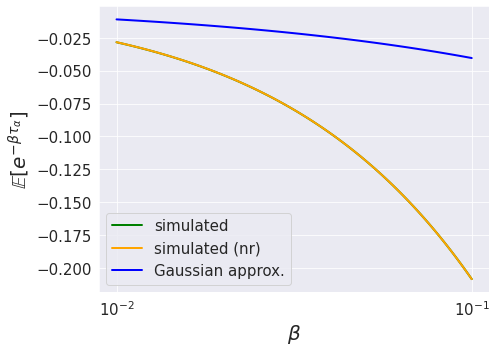

In [18]:
xx = np.logspace(-2, -1, 100)

with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)
    
    ax.plot(xx, empirical_log_laplace_transform(xx), color='green', linewidth=2, label='simulated')
#     ax.fill_between(xx, y1=empirical_log_laplace_transform_q_25(xx), y2=empirical_log_laplace_transform_q_75(xx), alpha=0.2, color='green', linewidth=2)
    
    ax.plot(xx, empirical_nr_log_laplace_transform(xx), color='orange', linewidth=2, label='simulated (nr)')
#     ax.fill_between(xx, y1=empirical_nr_log_laplace_transform_q_25(xx), y2=empirical_nr_log_laplace_transform_q_75(xx), alpha=0.2, color='orange', linewidth=2)
    
    ax.plot(xx, invgausslog_laplace_transform(xx), color='blue', linewidth=2, label='Gaussian approx.')
    
    ax.set_xscale('log')

    ax.legend(loc='lower left', prop={'size': 15})
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.set_xlabel(r'$\beta$', fontsize=20)
    ax.set_ylabel(r'$\mathbb{E}[e^{-\beta \tau_{\alpha}}]$', fontsize=20)
    
    plt.tight_layout()
    plt.show()